## KNN (K Nearest Neighbours) – K najbliższych sąsiadów

In [25]:
import warnings
warnings.filterwarnings('ignore')
from numpy import where
from numpy import meshgrid
from numpy import arange
from numpy import hstack


def plot_classification_surface(X_plot, y_plot, trained_model):
    plt.figure(figsize=(12, 7))

    # określenie granic zbioru
    min1, max1 = X_plot[:, 0].min()-1, X_plot[:, 0].max()+1
    min2, max2 = X_plot[:, 1].min()-1, X_plot[:, 1].max()+1

    # skalowanie dla obu osi
    x1grid = arange(min1, max1, 0.1)
    x2grid = arange(min2, max2, 0.1)

    # utworzenie siatki
    xx, yy = meshgrid(x1grid, x2grid)

    # przetworzenie siatki w wektor
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # stworzenie zmiennych objaśniających dla modelu
    grid = hstack((r1,r2))

    # predykcja modelu zbioru
    yhat = trained_model.predict(grid)


    # przetworzenie predykcji na decyzji dla konkretnego punktu wykresu
    zz = yhat.reshape(xx.shape)

    # wizualizacja siatki z przyporządkowaną klasą
    plt.contourf(xx, yy, zz, cmap='Paired')

    # tworzenie wykresu punktowego dla klas ze zbioru X
    for class_value in range(2):

        # przyporządkowanie klasy (y) do obsewacji (X)
        row_ix = where(y_plot == class_value)

        # stworzenie wykresu punktowego
        plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)

    # wizualizacja wykresu
    plt.legend(loc='upper right')
    plt.show()


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import pandas as pd
diabetes = pd.read_csv('diabetes.csv')

features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
target = 'Diabetic'
X, y = diabetes[features], diabetes[target]

X_train, X_test, y_train, y_test = train_test_split(X[['Pregnancies', 'Age']], y, test_size=0.30, random_state=0, stratify=y)
print ('Treningowe obserwacje: %d\nTestowe obserwacje: %d' % (X_train.shape[0], X_test.shape[0]))

scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)
model_lr = LogisticRegression()
model_lr.fit(X_train_standardized, y_train)

Treningowe obserwacje: 10500
Testowe obserwacje: 4500


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


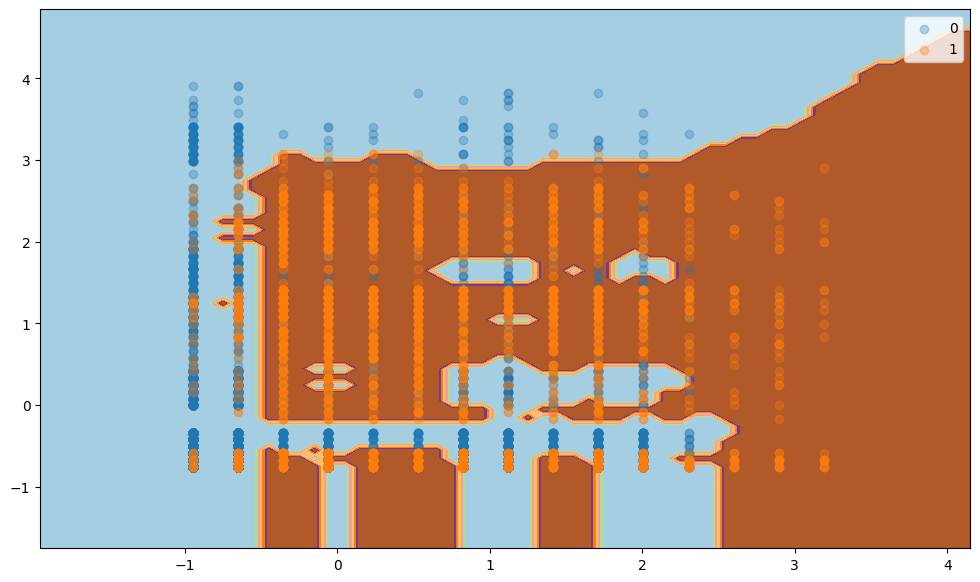

In [27]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

model_knn = KNeighborsClassifier(n_neighbors=int(X_train_standardized.shape[0]*0.001))
model_knn.fit(X_train_standardized, y_train)
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_knn)

In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    new_row = pd.DataFrame([{'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric}])
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    return metrics_dataframe

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



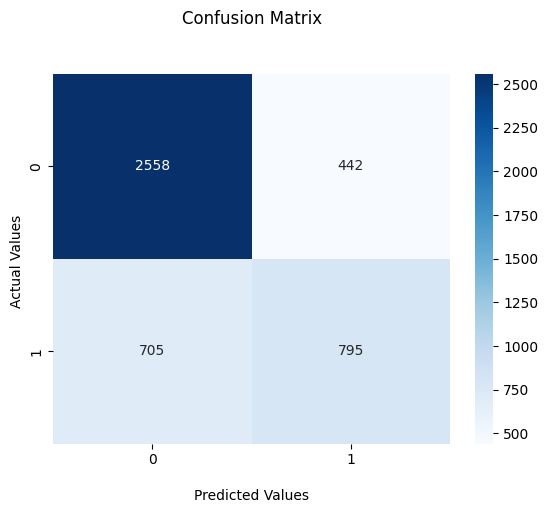

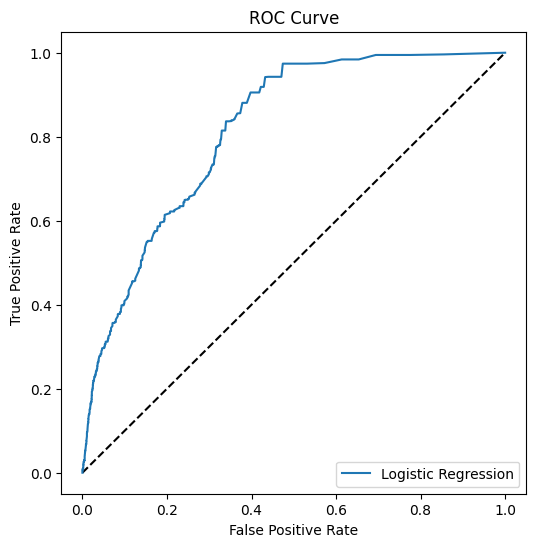

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3000
           1       0.81      0.81      0.81      1500

    accuracy                           0.88      4500
   macro avg       0.86      0.86      0.86      4500
weighted avg       0.88      0.88      0.88      4500



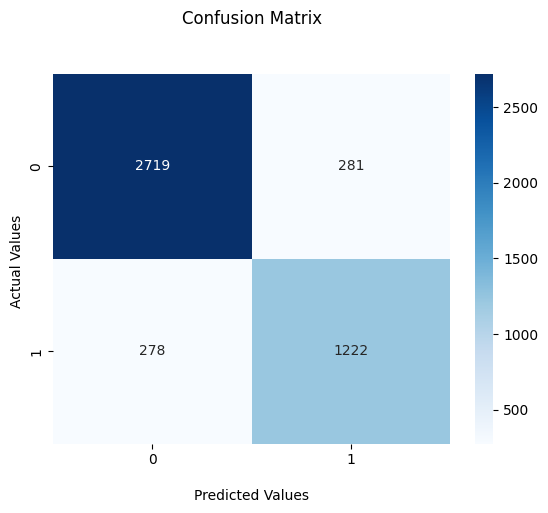

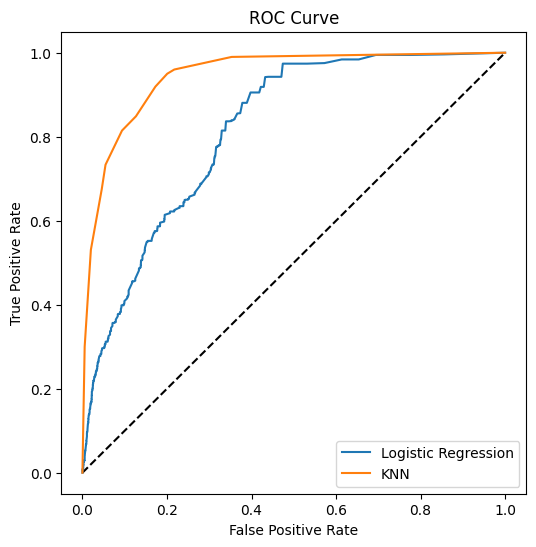

,Model,F1_score,AUC
0,Logistic Regression,0.580928,0.816493
1,KNN,0.813853,0.945118


In [29]:
calculate_metrics(model_lr, 'Logistic Regression', X_test_standardized, y_test)
calculate_metrics(model_knn, 'KNN', X_test_standardized, y_test)

In [30]:
#oblicz F1_score
def f1_scoring(model, X_checked, y_checked):
    predictions = model.predict(X_checked)
    print("F1_score: {}".format(f1_score(y_checked, predictions)))

In [31]:
f1_scoring(model_knn, X_test_standardized, y_test)

F1_score: 0.8138528138528138


## Drzewo decyzyjne

In [32]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=int(X_train.shape[0]*0.001))
model_tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


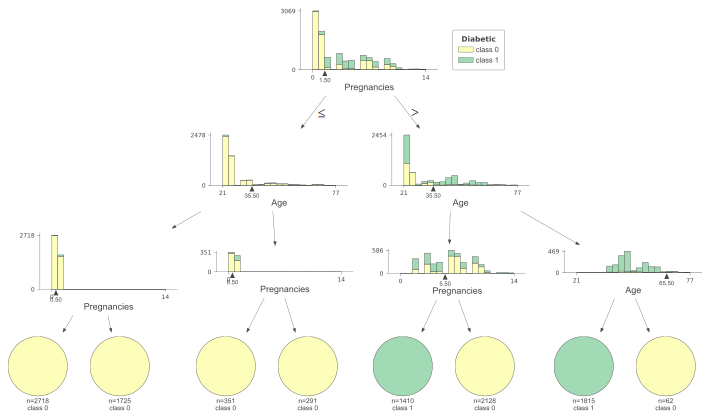

In [33]:
from dtreeviz import trees


viz = trees.dtreeviz(model_tree, x_data=X_train, y_data=y_train,target_name='Diabetic', feature_names = X_train.columns)
viz

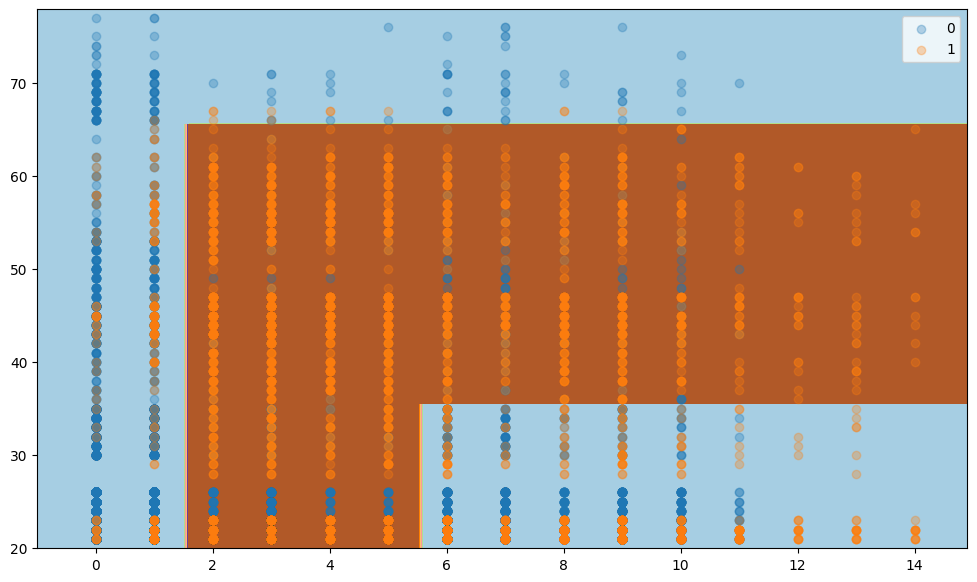

In [34]:
import numpy as np

plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_tree)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      3000
           1       0.80      0.76      0.78      1500

    accuracy                           0.86      4500
   macro avg       0.84      0.83      0.84      4500
weighted avg       0.86      0.86      0.86      4500



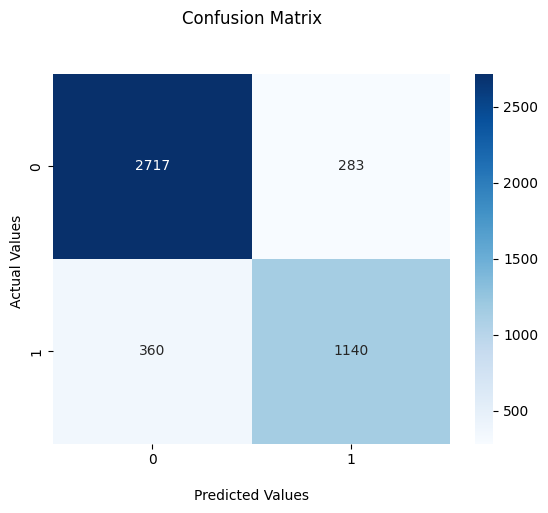

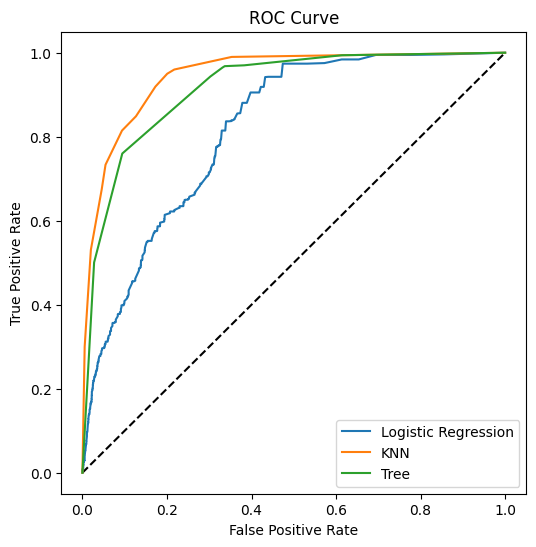

,Model,F1_score,AUC
0,Logistic Regression,0.580928,0.816493
1,KNN,0.813853,0.945118
2,Tree,0.780021,0.915466


In [35]:
calculate_metrics(model_tree, 'Tree', X_test, y_test)

In [36]:
# model_tree_2 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=int(X_train.shape[0]*0.0005))
# model_tree_2.fit(X_train, y_train)
# plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_tree_2)
# calculate_metrics(model_tree_2, 'Tree2', X_test, y_test)

In [37]:
# model_tree_5 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=int(X_train.shape[0]*0.0001))
# model_tree_5.fit(X_train, y_train)
# plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_tree_5)
# calculate_metrics(model_tree_5, 'Tree5', X_test, y_test)

### Random Forest – Las drzew decyzyjnych

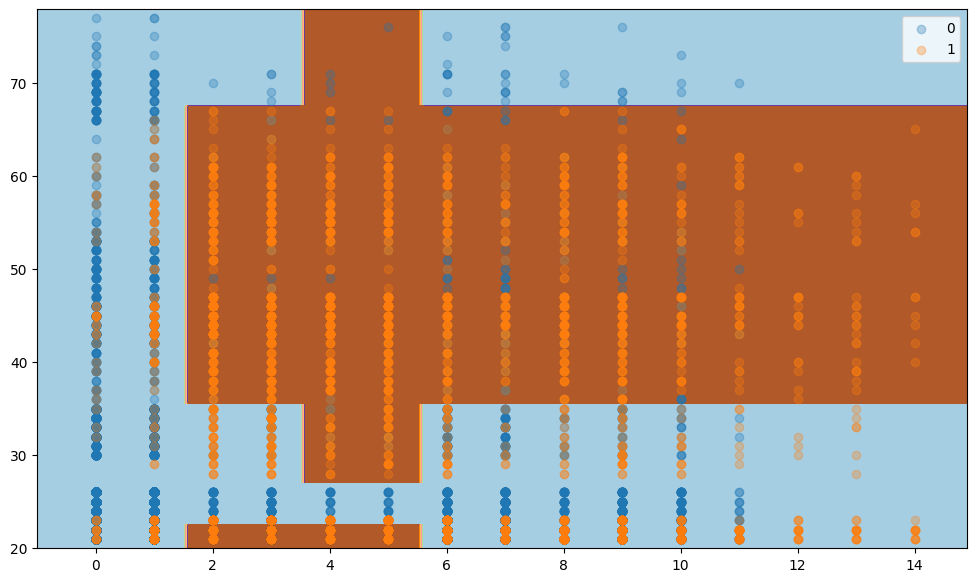

In [38]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(n_estimators=1000, max_depth=3, min_samples_leaf=int(X_train.shape[0]*0.001))
model_forest.fit(X_train, y_train)
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_forest)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3000
           1       0.86      0.70      0.77      1500

    accuracy                           0.86      4500
   macro avg       0.86      0.82      0.83      4500
weighted avg       0.86      0.86      0.86      4500



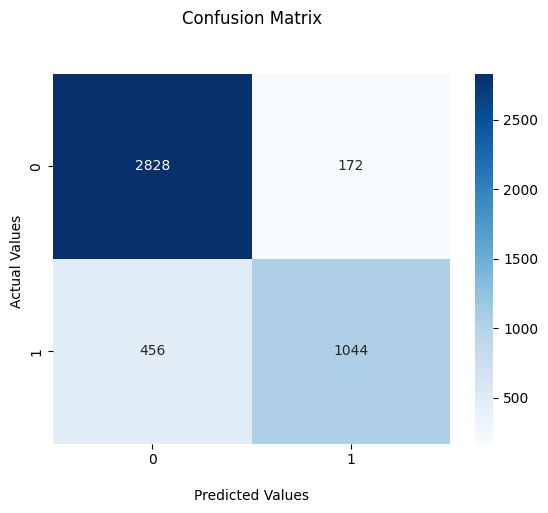

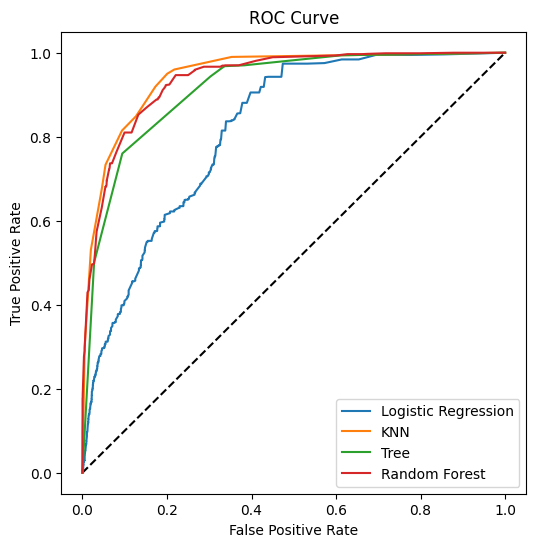

,Model,F1_score,AUC
0,Logistic Regression,0.580928,0.816493
1,KNN,0.813853,0.945118
2,Tree,0.780021,0.915466
3,Random Forest,0.768778,0.937397


In [39]:
calculate_metrics(model_forest, 'Random Forest', X_test, y_test)

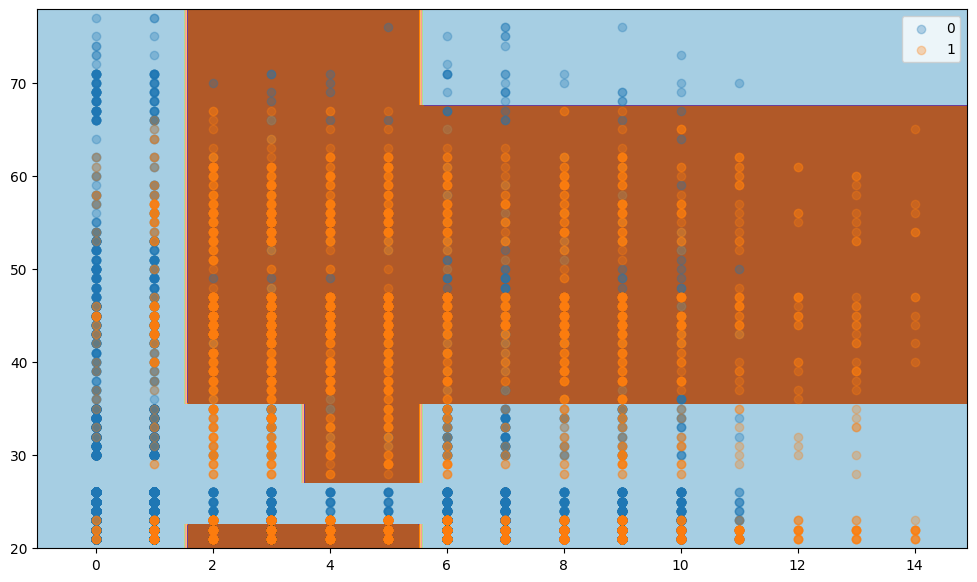

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3000
           1       0.86      0.70      0.77      1500

    accuracy                           0.86      4500
   macro avg       0.86      0.82      0.83      4500
weighted avg       0.86      0.86      0.86      4500



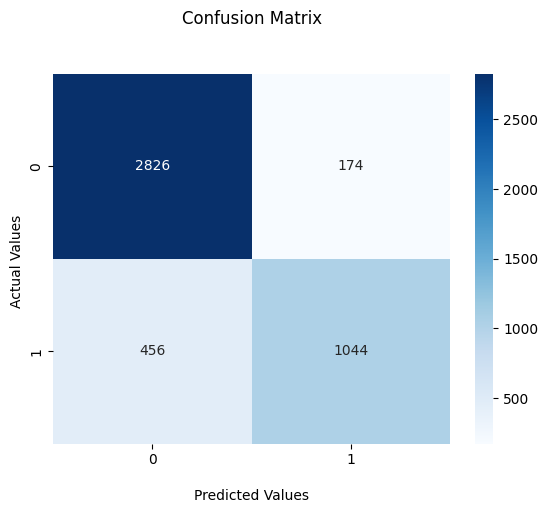

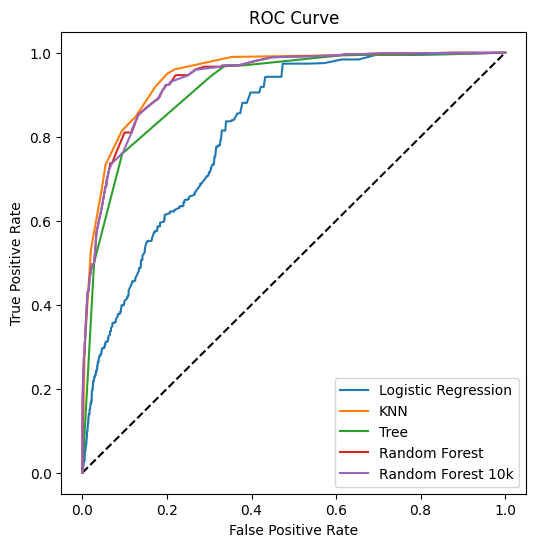

,Model,F1_score,AUC
0,Logistic Regression,0.580928,0.816493
1,KNN,0.813853,0.945118
2,Tree,0.780021,0.915466
3,Random Forest,0.768778,0.937397
4,Random Forest 10k,0.768212,0.936071


In [41]:
model_forest_10k = RandomForestClassifier(n_estimators=1000, max_depth=3, min_samples_leaf=int(X_train.shape[0]*0.001))
model_forest_10k.fit(X_train, y_train)
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_forest_10k)
calculate_metrics(model_forest_10k, 'Random Forest 10k', X_test, y_test)

### Boosting — AdaBoost

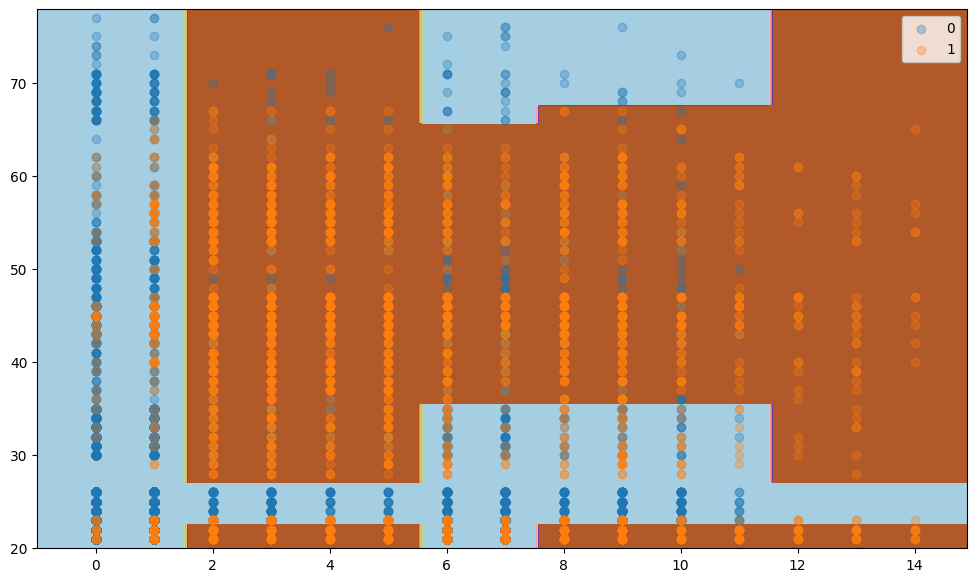

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      3000
           1       0.81      0.81      0.81      1500

    accuracy                           0.87      4500
   macro avg       0.86      0.86      0.86      4500
weighted avg       0.87      0.87      0.87      4500



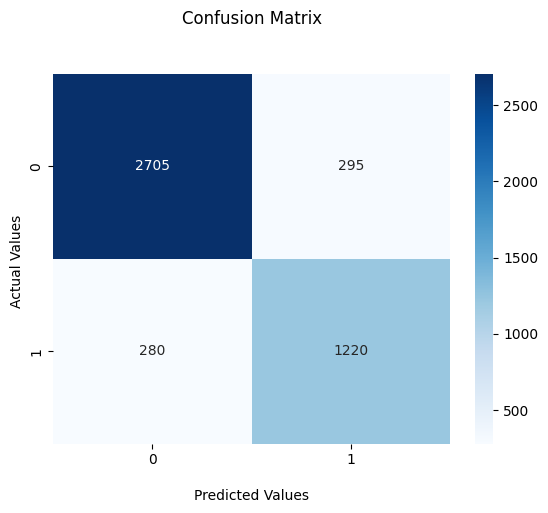

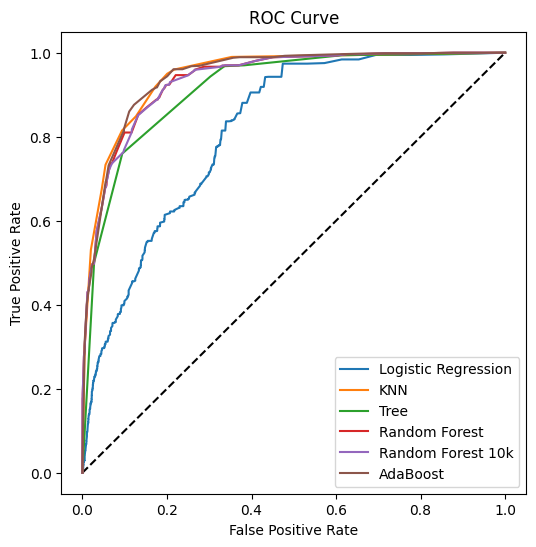

,Model,F1_score,AUC
0,Logistic Regression,0.580928,0.816493
1,KNN,0.813853,0.945118
2,Tree,0.780021,0.915466
3,Random Forest,0.768778,0.937397
4,Random Forest 10k,0.768212,0.936071
5,AdaBoost,0.809287,0.944256


In [44]:
from sklearn.ensemble import AdaBoostClassifier

model_adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50)
model_adaboost.fit(X_train, y_train)
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_adaboost)
calculate_metrics(model_adaboost, 'AdaBoost', X_test, y_test)

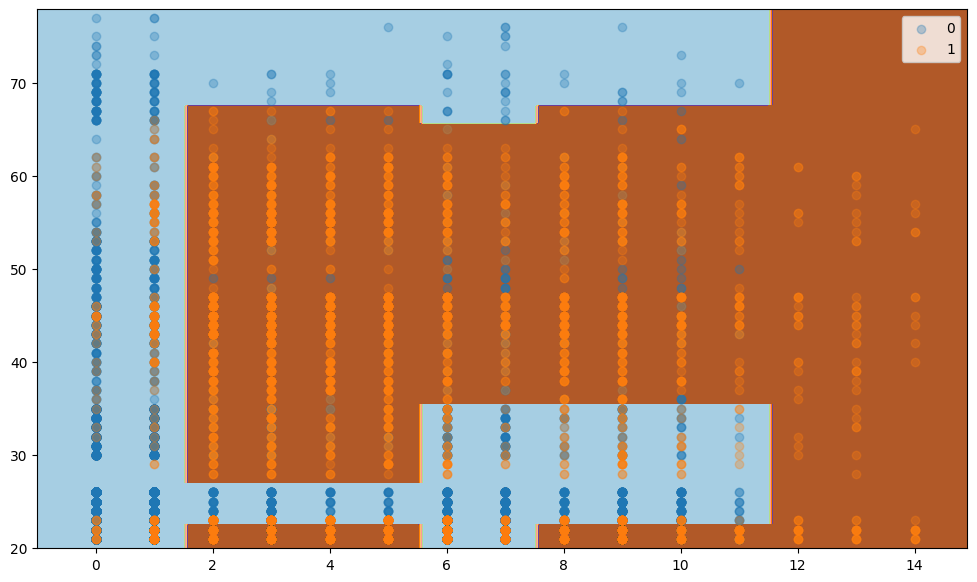

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      3000
           1       0.81      0.82      0.81      1500

    accuracy                           0.87      4500
   macro avg       0.86      0.86      0.86      4500
weighted avg       0.87      0.87      0.87      4500



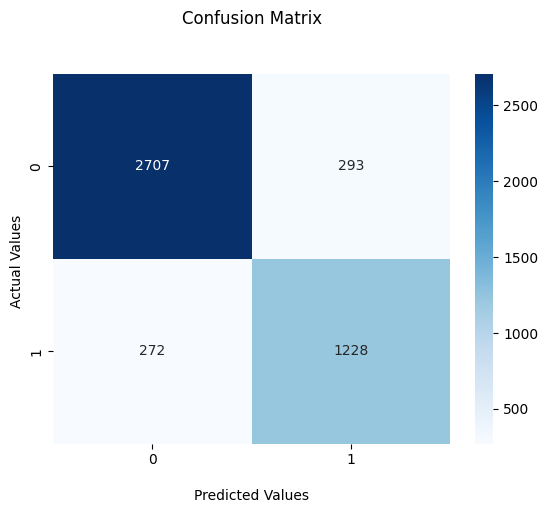

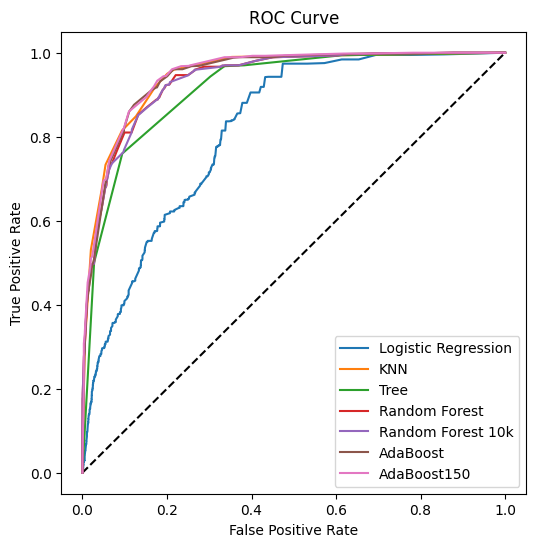

,Model,F1_score,AUC
0,Logistic Regression,0.580928,0.816493
1,KNN,0.813853,0.945118
2,Tree,0.780021,0.915466
3,Random Forest,0.768778,0.937397
4,Random Forest 10k,0.768212,0.936071
5,AdaBoost,0.809287,0.944256
6,AdaBoost150,0.812976,0.947657


In [45]:
from sklearn.ensemble import AdaBoostClassifier

model_adaboost_150 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=150)
model_adaboost_150.fit(X_train, y_train)
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_adaboost_150)
calculate_metrics(model_adaboost_150, 'AdaBoost150', X_test, y_test)

### Ensembling – Zespół klasyfikatorów

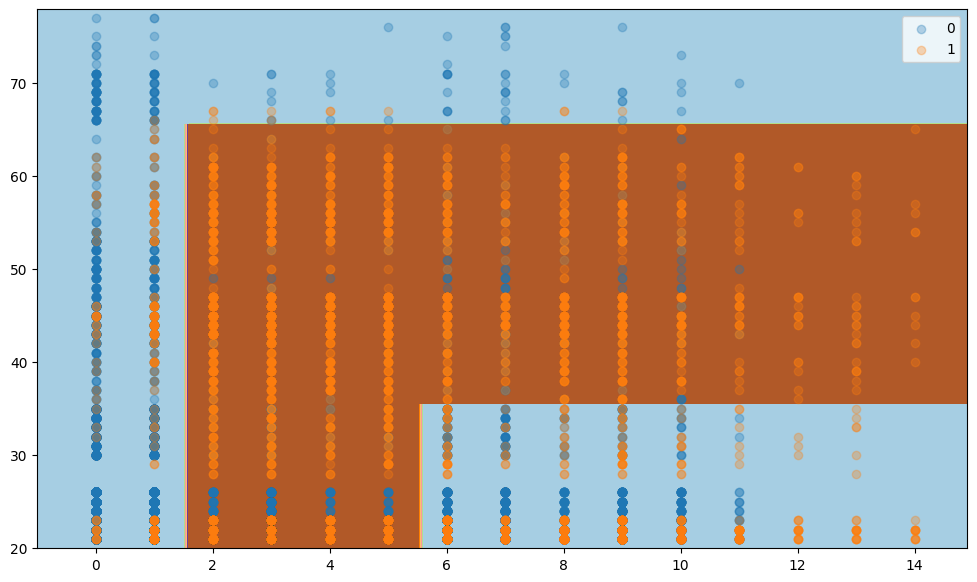

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      3000
           1       0.80      0.76      0.78      1500

    accuracy                           0.86      4500
   macro avg       0.84      0.83      0.84      4500
weighted avg       0.86      0.86      0.86      4500



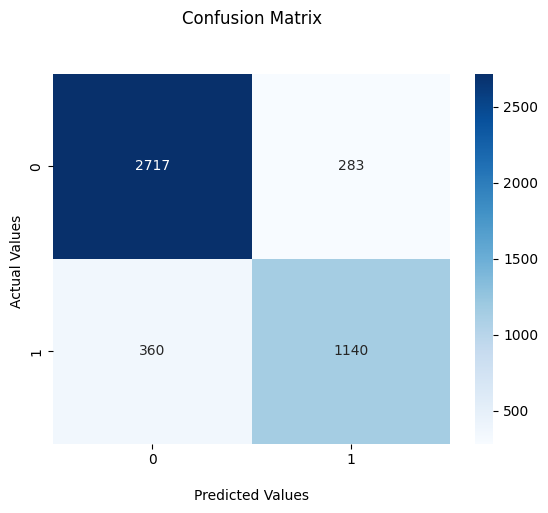

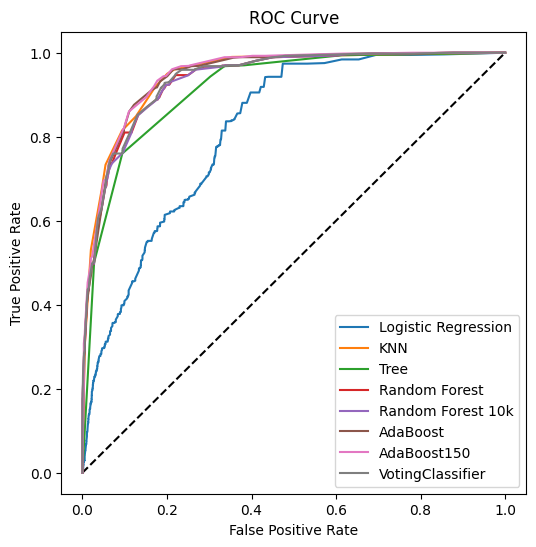

,Model,F1_score,AUC
0,Logistic Regression,0.580928,0.816493
1,KNN,0.813853,0.945118
2,Tree,0.780021,0.915466
3,Random Forest,0.768778,0.937397
4,Random Forest 10k,0.768212,0.936071
5,AdaBoost,0.809287,0.944256
6,AdaBoost150,0.812976,0.947657
7,VotingClassifier,0.780021,0.938662


In [47]:
from sklearn.ensemble import VotingClassifier

model_voting = VotingClassifier(estimators=[('Tree', model_tree),
                                            ('Random Forest', model_forest),
                                            ('AdaBoost', model_adaboost)],
                                voting='soft')

model_voting.fit(X_train, y_train)
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_voting)
calculate_metrics(model_voting, 'VotingClassifier', X_test, y_test)

### Klasyfikacja na podstawie wielu zmiennych

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

In [59]:
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
params_rf = {'max_depth': [3, 5, 10, 20],
             'min_samples_leaf': [3, 5, 10, 15]}
rf_gridsearch = GridSearchCV(random_forest,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
rf_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
rf_model_v2 = rf_gridsearch.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameter: {'max_depth': 20, 'min_samples_leaf': 3}


              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3000
           1       0.92      0.90      0.91      1500

    accuracy                           0.94      4500
   macro avg       0.93      0.93      0.93      4500
weighted avg       0.94      0.94      0.94      4500



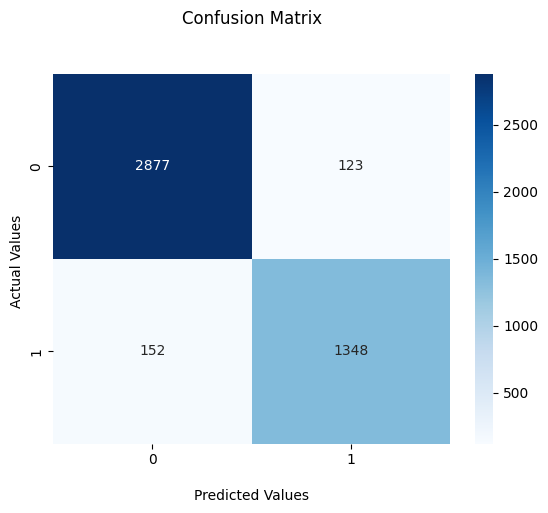

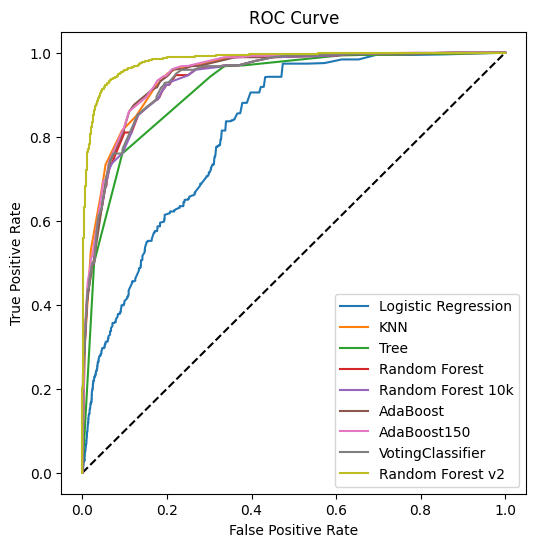

,Model,F1_score,AUC
0,Logistic Regression,0.580928,0.816493
1,KNN,0.813853,0.945118
2,Tree,0.780021,0.915466
3,Random Forest,0.768778,0.937397
4,Random Forest 10k,0.768212,0.936071
5,AdaBoost,0.809287,0.944256
6,AdaBoost150,0.812976,0.947657
7,VotingClassifier,0.780021,0.938662
8,Random Forest v2,0.907439,0.982396


[CV 1/5; 1/16] START max_depth=3, min_samples_leaf=3............................
[CV 1/5; 1/16] END max_depth=3, min_samples_leaf=3;, score=0.893 total time=   3.4s
[CV 2/5; 3/16] START max_depth=3, min_samples_leaf=10...........................
[CV 2/5; 3/16] END max_depth=3, min_samples_leaf=10;, score=0.893 total time=   3.5s
[CV 5/5; 5/16] START max_depth=5, min_samples_leaf=3............................
[CV 5/5; 5/16] END max_depth=5, min_samples_leaf=3;, score=0.906 total time=   4.7s
[CV 5/5; 7/16] START max_depth=5, min_samples_leaf=10...........................
[CV 5/5; 7/16] END max_depth=5, min_samples_leaf=10;, score=0.906 total time=   4.8s
[CV 3/5; 10/16] START max_depth=10, min_samples_leaf=5..........................
[CV 3/5; 10/16] END max_depth=10, min_samples_leaf=5;, score=0.922 total time=   6.8s
[CV 1/5; 12/16] START max_depth=10, min_samples_leaf=15.........................
[CV 1/5; 12/16] END max_depth=10, min_samples_leaf=15;, score=0.915 total time=   6.4s
[CV

[CV 4/5; 2/16] START max_depth=3, min_samples_leaf=5............................
[CV 4/5; 2/16] END max_depth=3, min_samples_leaf=5;, score=0.896 total time=   3.6s
[CV 3/5; 4/16] START max_depth=3, min_samples_leaf=15...........................
[CV 3/5; 4/16] END max_depth=3, min_samples_leaf=15;, score=0.891 total time=   3.6s
[CV 4/5; 6/16] START max_depth=5, min_samples_leaf=5............................
[CV 4/5; 6/16] END max_depth=5, min_samples_leaf=5;, score=0.909 total time=   4.7s
[CV 4/5; 8/16] START max_depth=5, min_samples_leaf=15...........................
[CV 4/5; 8/16] END max_depth=5, min_samples_leaf=15;, score=0.906 total time=   4.5s
[CV 4/5; 10/16] START max_depth=10, min_samples_leaf=5..........................
[CV 4/5; 10/16] END max_depth=10, min_samples_leaf=5;, score=0.928 total time=   7.0s
[CV 3/5; 12/16] START max_depth=10, min_samples_leaf=15.........................
[CV 3/5; 12/16] END max_depth=10, min_samples_leaf=15;, score=0.916 total time=   6.6s
[CV

In [50]:
calculate_metrics(rf_gridsearch, 'Random Forest v2', X_test, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best hyperparameter: {'n_estimators': 15}
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3000
           1       0.85      0.91      0.88      1500

    accuracy                           0.92      4500
   macro avg       0.90      0.92      0.91      4500
weighted avg       0.92      0.92      0.92      4500



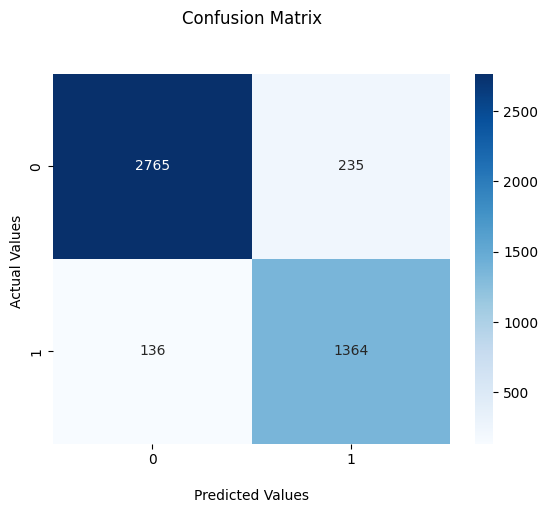

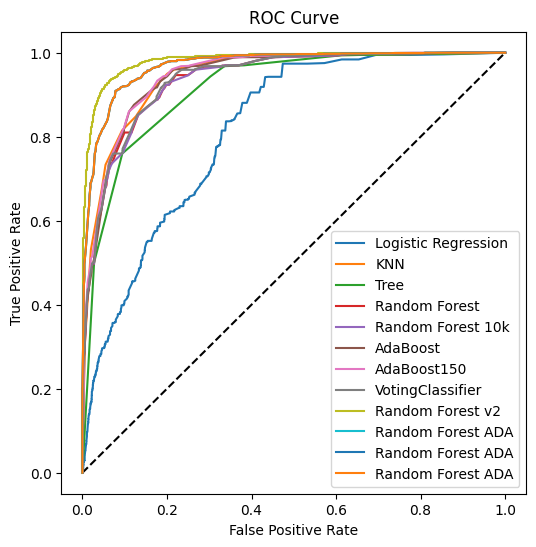

,Model,F1_score,AUC
0,Logistic Regression,0.580928,0.816493
1,KNN,0.813853,0.945118
2,Tree,0.780021,0.915466
3,Random Forest,0.768778,0.937397
4,Random Forest 10k,0.768212,0.936071
5,AdaBoost,0.809287,0.944256
6,AdaBoost150,0.812976,0.947657
7,VotingClassifier,0.780021,0.938662
8,Random Forest v2,0.907439,0.982396
9,Random Forest ADA,0.880284,0.969829


[CV 4/5; 2/4] START n_estimators=5..............................................
[CV 4/5; 2/4] END ...............n_estimators=5;, score=0.869 total time=   0.0s
[CV 3/5; 1/4] START n_estimators=3..............................................
[CV 3/5; 1/4] END ...............n_estimators=3;, score=0.837 total time=   0.0s
[CV 4/5; 3/4] START n_estimators=10.............................................
[CV 4/5; 3/4] END ..............n_estimators=10;, score=0.894 total time=   0.1s
[CV 1/5; 2/4] START n_estimators=5..............................................
[CV 1/5; 2/4] END ...............n_estimators=5;, score=0.874 total time=   0.0s
[CV 5/5; 1/4] START n_estimators=3..............................................
[CV 5/5; 1/4] END ...............n_estimators=3;, score=0.830 total time=   0.0s
[CV 5/5; 3/4] START n_estimators=10.............................................
[CV 5/5; 3/4] END ..............n_estimators=10;, score=0.860 total time=   0.1s
[CV 5/5; 2/4] START n_estima

In [64]:
from sklearn.model_selection import GridSearchCV

# random_forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
model_adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
params_rf = {'n_estimators': [3, 5, 10, 15]}
rf_gridsearch_ada = GridSearchCV(model_adaboost,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
rf_gridsearch_ada.fit(X_train, y_train)
print('\nBest hyperparameter:', rf_gridsearch_ada.best_params_)
rf_model_v2 = rf_gridsearch_ada.best_estimator_
calculate_metrics(rf_gridsearch_ada, 'Random Forest ADA', X_test, y_test)